# Binary Classification Model for Online News Popularity Using Python Take 2
### David Lowe
### November 19, 2018

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Online News Popularity dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the article's popularity level in social networks. The dataset does not contain the original content but some statistics associated with it. The original content can be publicly accessed and retrieved using the provided URLs.

Many thanks to K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal, for making the dataset and benchmarking information available.

In iteration Take1, the script focused on evaluating various machine learning algorithms and identifying the algorithm that produces the best accuracy result. Iteration Take1 established a baseline performance regarding accuracy and processing time.

For this iteration, we will examine the feasibility of using a dimensionality reduction technique of ranking the attribute importance with a gradient boosting tree method. Afterward, we will eliminate the features that do not contribute to the cumulative importance of 0.99 (or 99%).

ANALYSIS: From the previous iteration Take1, the baseline performance of the machine learning algorithms achieved an average accuracy of 59.95%. Three algorithms (Bagged CART, AdaBoost, and Stochastic Gradient Boosting) achieved the top three accuracy scores after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top result using the training data. It achieved an average accuracy of 67.38%. Using the optimized tuning parameter available, the Stochastic Gradient Boosting algorithm processed the validation dataset with an accuracy of 66.89%, which was just slightly worse than the training data.

In the current iteration, the baseline performance of the machine learning algorithms achieved an average accuracy of 60.60%. Two ensemble algorithms (Bagged CART and Stochastic Gradient Boosting) achieved the top accuracy scores after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top result using the training data. It achieved an average accuracy of 67.34%. Using the optimized tuning parameter available, the Stochastic Gradient Boosting algorithm processed the validation dataset with an accuracy of 66.70%, which was just slightly below the accuracy of the training data.

From the model-building activities, the number of attributes went from 58 down to 44 after eliminating 14 attributes. The processing time went from 5 hours 56 minutes in iteration Take1 down to 1 hour 59 minutes in iteration Take2, which was a reduction of 66% from Take1.

CONCLUSION: The feature selection techniques helped by cutting down the attributes and reduced the training time. Furthermore, the modeling took a much shorter time to process yet still retained a comparable level of accuracy. For this dataset, the Stochastic Gradient Boosting algorithm and the attribute importance ranking technique should be considered for further modeling or production use.

Dataset Used: Online News Popularity Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from datetime import datetime
import smtplib
from email.message import EmailMessage

# Create one random seed number for reproducible results
seedNum = 888

C:\Users\david.lowe\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 1.b) Load dataset

In [2]:
startTimeScript = datetime.now()

inputFile = 'OnlineNewsPopularity.csv'
xy_original = read_csv(inputFile)
xy_original.columns = xy_original.columns.str.replace(' ','')

# Using the "shares" column to set up the target variable column
# targetVar <- 0 (or "not popular") when shares < 1400
# targetVar <- 1 (or "popular") when shares >= 1400
xy_original['targetVar'] = 0
xy_original['targetVar'] = np.where(xy_original['shares']>=1400, 1, xy_original['targetVar'])
xy_original.drop('shares', axis=1, inplace=True)

# Dropping the two non-predictive attributes: url and timedelta
xy_original.drop('url', axis=1, inplace=True)
xy_original.drop('timedelta', axis=1, inplace=True)

In [3]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [4]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if the column name is known
# xy_original = xy_original.rename(columns={'outcome': 'targetVar'})

In [5]:
# We create training datasets (xy_train, x_train, y_train) for various operations
# We create validation datasets (xy_test, x_test, y_test) for various operations
# Use 70% of the data to train the models and the remaining for testing/validation
array = xy_original.values

if targetCol == totCol :
    x_original = array[:,0:totAttr]
    y_original = array[:,totAttr]
else :
    x_original = array[:,1:totCol]
    y_original = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_original, y_original, test_size=validation_size, random_state=seedNum)
print("x_original.shape: {} y_original.shape: {}".format(x_original.shape, y_original.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_original.shape: (39644, 58) y_original.shape: (39644,)
x_train.shape: (27750, 58) y_train.shape: (27750,)
x_test.shape: (11894, 58) y_test.shape: (11894,)


### 1.c) Set up the key parameters to be used in the script

In [6]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

### 1.d) Set up the email notification function

In [7]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [8]:
email_notify("Library and Data Loading Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [9]:
xy_original.head(10)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,targetVar
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0
5,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,0.0,4.359459,...,0.136364,0.6,-0.195000,-0.400,-0.100000,0.642857,0.214286,0.142857,0.214286,0
6,8.0,960.0,0.418163,1.0,0.549834,21.0,20.0,20.0,0.0,4.654167,...,0.100000,1.0,-0.224479,-0.500,-0.050000,0.000000,0.000000,0.500000,0.000000,0
7,12.0,989.0,0.433574,1.0,0.572108,20.0,20.0,20.0,0.0,4.617796,...,0.100000,1.0,-0.242778,-0.500,-0.050000,1.000000,0.500000,0.500000,0.500000,0
8,11.0,97.0,0.670103,1.0,0.836735,2.0,0.0,0.0,0.0,4.855670,...,0.400000,0.8,-0.125000,-0.125,-0.125000,0.125000,0.000000,0.375000,0.000000,1
9,10.0,231.0,0.636364,1.0,0.797101,4.0,1.0,1.0,1.0,5.090909,...,0.100000,0.5,-0.238095,-0.500,-0.100000,0.000000,0.000000,0.500000,0.000000,0


#### 2.a.ii) Dimensions of the dataset.

In [10]:
xy_original.shape

(39644, 59)

#### 2.a.iii) Types of the attributes.

In [11]:
xy_original.dtypes

n_tokens_title                   float64
n_tokens_content                 float64
n_unique_tokens                  float64
n_non_stop_words                 float64
n_non_stop_unique_tokens         float64
num_hrefs                        float64
num_self_hrefs                   float64
num_imgs                         float64
num_videos                       float64
average_token_length             float64
num_keywords                     float64
data_channel_is_lifestyle        float64
data_channel_is_entertainment    float64
data_channel_is_bus              float64
data_channel_is_socmed           float64
data_channel_is_tech             float64
data_channel_is_world            float64
kw_min_min                       float64
kw_max_min                       float64
kw_avg_min                       float64
kw_min_max                       float64
kw_max_max                       float64
kw_avg_max                       float64
kw_min_avg                       float64
kw_max_avg      

#### 2.a.iv) Statistical summary of all attributes.

In [12]:
xy_original.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,targetVar
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,0.533599
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,0.498876
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,1.000000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000


#### 2.a.v) Count missing values.

In [13]:
xy_original.isnull().sum()

n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_shares        0
self_reference_max_shares        0
self_reference_avg_s

#### 2.a.vi) Summarize the levels of the class attribute.

In [14]:
xy_original.groupby('targetVar').size()

targetVar
0    18490
1    21154
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

In [15]:
x_original = xy_original.drop(columns=['targetVar'])

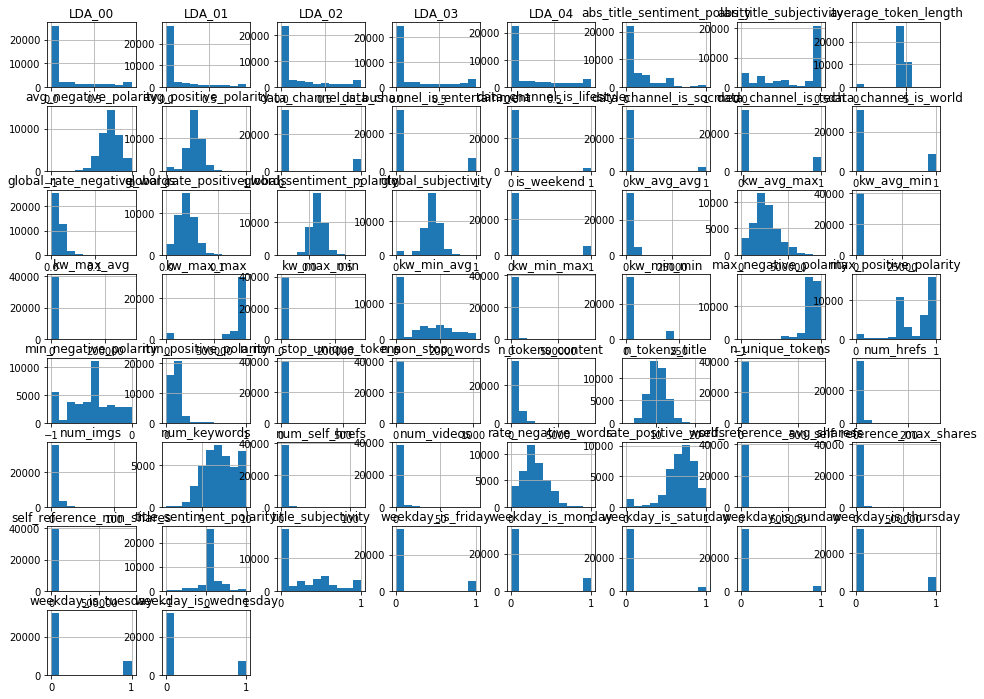

In [16]:
# Histograms for each attribute
x_original.hist()
pyplot.show()

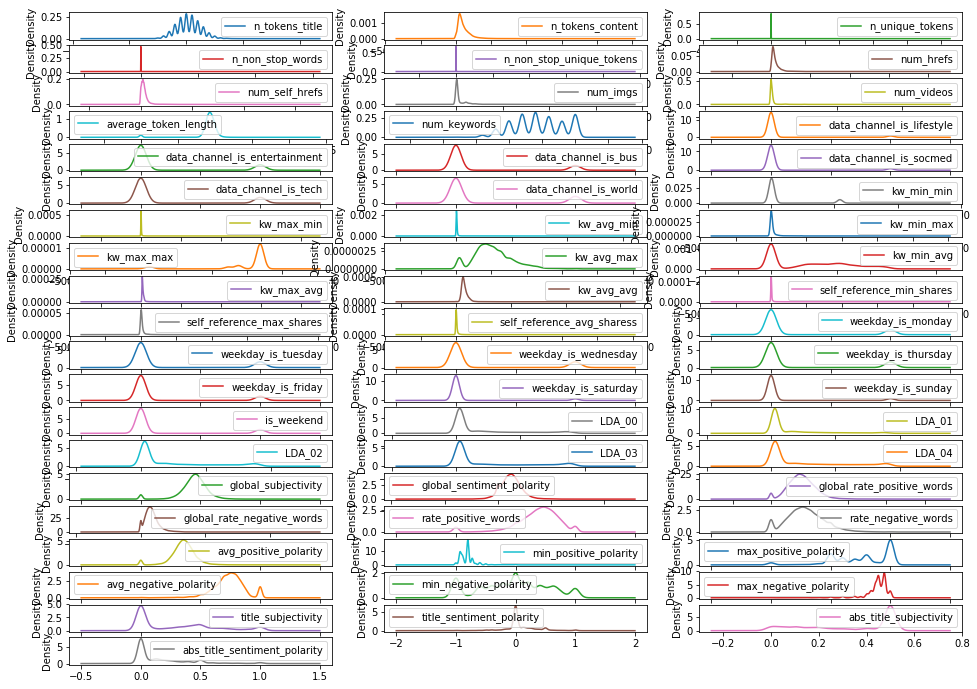

In [17]:
# Density plot for each attribute
x_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

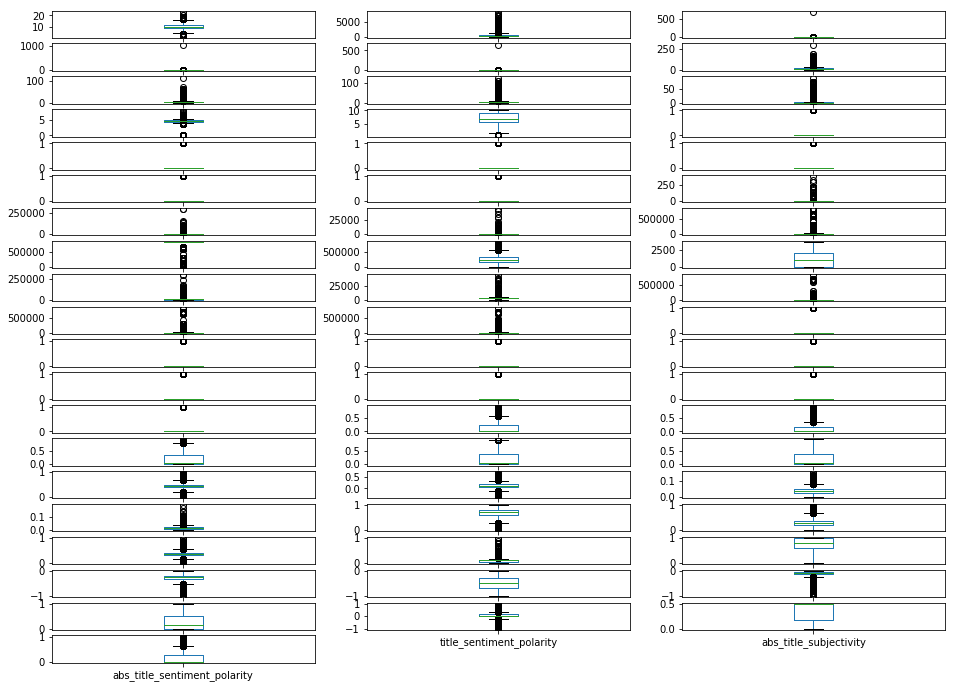

In [18]:
# Box and Whisker plot for each attribute
x_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [19]:
# Scatterplot matrix
# scatter_matrix(x_original)
# pyplot.show()

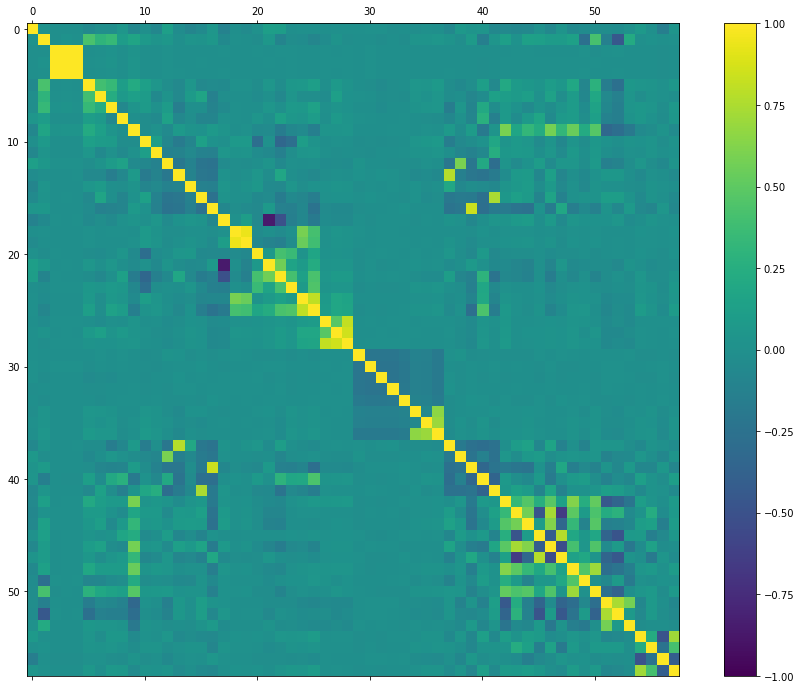

In [20]:
# Correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(x_original.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [21]:
email_notify("Data Summary and Visualization Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

### 3.a) Data Cleaning

In [22]:
# Not applicable for this iteration of the project.

### 3.b) Feature Selection

In [23]:
# Feature Importance with Extra Trees Classifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
importanceScore = model.feature_importances_
attributeList = xy_original.columns
attributeList = xy_original.columns.tolist()
if targetCol == totCol :
    del attributeList[-1]
else :
    del attributeList[0]
attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
print(rankedAttributes)

                        attribute  importance
25                     kw_avg_avg    0.064144
26      self_reference_min_shares    0.057189
23                     kw_min_avg    0.049519
2                 n_unique_tokens    0.046017
37                         LDA_00    0.045303
36                     is_weekend    0.043816
24                     kw_max_avg    0.042490
28     self_reference_avg_sharess    0.036571
21                     kw_max_max    0.035750
19                     kw_avg_min    0.034280
15           data_channel_is_tech    0.031763
5                       num_hrefs    0.029200
39                         LDA_02    0.028331
44     global_rate_positive_words    0.026896
14         data_channel_is_socmed    0.025772
42            global_subjectivity    0.024613
7                        num_imgs    0.023311
17                     kw_min_min    0.023127
38                         LDA_01    0.023014
22                     kw_avg_max    0.022537
49          min_positive_polarity 

In [24]:
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
maxThreshold = 0.99
i = 0
accumWeight = 0
exit_now = False
while ((i < totAttr) and (not exit_now)) :
    accumWeight = accumWeight + rankedAttributes.iloc[i]['importance']
    if (accumWeight >= maxThreshold) :
        exit_now = True
    else :
        i = i + 1
print('Number of attributes contributed to the importance threshold:'+str(i))
lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
print('Number of attributes found to be of low importance:',len(lowAttributes))
print(lowAttributes)

Number of attributes contributed to the importance threshold:44
Number of attributes found to be of low importance: 14
['max_negative_polarity', 'avg_positive_polarity', 'abs_title_sentiment_polarity', 'self_reference_max_shares', 'weekday_is_sunday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'max_positive_polarity', 'rate_positive_words', 'weekday_is_thursday', 'data_channel_is_bus', 'data_channel_is_lifestyle', 'n_non_stop_words', 'weekday_is_monday']


In [25]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = xy_original.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
array = xy_newdf.values

if targetCol == totCol :
    x_newdf = array[:,0:totAttr]
    y_newdf = array[:,totAttr]
else :
    x_newdf = array[:,1:totCol]
    y_newdf = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (39644, 44) y_newdf.shape: (39644,)
x_train.shape: (27750, 44) y_train.shape: (27750,)
x_test.shape: (11894, 44) y_test.shape: (11894,)


### 3.c) Data Transforms

In [26]:
# Not applicable for this iteration of the project.

### 3.d) Display the Final Dataset for Model-Building

In [27]:
x_train.shape

(27750, 44)

In [28]:
x_train

array([[ 7.00000000e+00,  5.52000000e+02,  4.60980035e-01, ...,
         0.00000000e+00,  0.00000000e+00,  5.00000000e-01],
       [ 1.30000000e+01,  3.74000000e+02,  5.33149170e-01, ...,
         0.00000000e+00,  0.00000000e+00,  5.00000000e-01],
       [ 1.20000000e+01,  9.90000000e+02,  4.60743801e-01, ...,
         1.00000000e-01, -1.00000000e-01,  4.00000000e-01],
       ...,
       [ 1.10000000e+01,  2.67000000e+02,  5.96226413e-01, ...,
         0.00000000e+00,  0.00000000e+00,  5.00000000e-01],
       [ 9.00000000e+00,  8.44000000e+02,  4.86227544e-01, ...,
         0.00000000e+00,  0.00000000e+00,  5.00000000e-01],
       [ 1.10000000e+01,  9.17000000e+02,  4.79737130e-01, ...,
         5.00000000e-01,  3.75000000e-01,  0.00000000e+00]])

In [29]:
y_train.shape

(27750,)

In [30]:
y_train

array([1., 0., 0., ..., 1., 0., 0.])

In [31]:
print ('Data handling time:',(datetime.now() - startTimeScript))

Data handling time: 0:04:16.257501


In [32]:
email_notify("Data Cleaning and Transformation Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, four non-linear and five ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART), k-Nearest Neighbors, and Support Vector Machine

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Stochastic Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [33]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [34]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression(random_state=seedNum)))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=seedNum)))
models.append(('BT', BaggingClassifier(random_state=seedNum)))
models.append(('RF', RandomForestClassifier(random_state=seedNum)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
results = []
names = []
metrics = []

In [35]:
# Generate model in turn
for name, model in models:
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify(name+" Modeling Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LR: 0.607604 (0.009834)
Model training time: 0:00:14.986420
CART: 0.581694 (0.006963)
Model training time: 0:00:09.795392
KNN: 0.572324 (0.006905)
Model training time: 0:00:05.956521
SVM: 0.535099 (0.006940)
Model training time: 0:40:21.568041
BT: 0.628108 (0.007257)
Model training time: 0:01:01.521726
RF: 0.624505 (0.006306)
Model training time: 0:00:08.913825
ET: 0.628973 (0.007038)
Model training time: 0:00:04.393483
GBM: 0.669982 (0.008809)
Model training time: 0:01:11.285132
Average metrics (accuracy) from all models: 0.6060360360360361


### 4.b) Spot-checking baseline algorithms

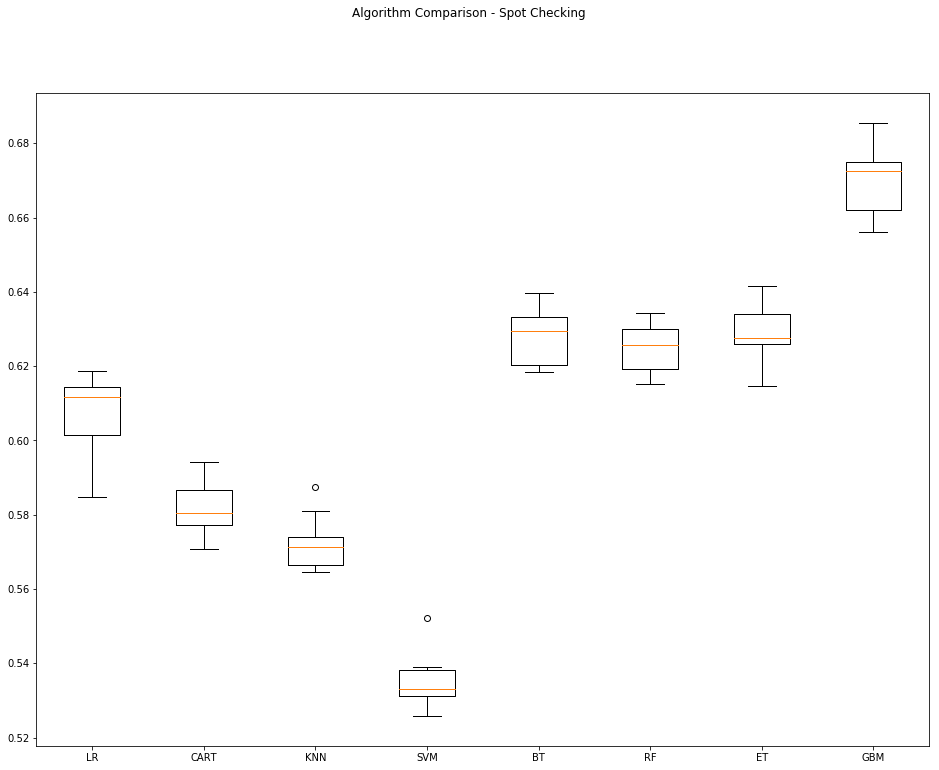

In [36]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [37]:
# Set up the comparison array
results = []
names = []

In [38]:
# Tuning algorithm #1 - Bagged CART
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([90,120,150,180]))
model1 = BaggingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BT')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
email_notify("Algorithm #1 Tuning Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Model training time:',(datetime.now() - startTimeModule))

Best: 0.667640 using {'n_estimators': 180}
0.662811 (0.010059) with: {'n_estimators': 90}
0.664036 (0.009624) with: {'n_estimators': 120}
0.665153 (0.007630) with: {'n_estimators': 150}
0.667640 (0.007682) with: {'n_estimators': 180}
Model training time: 0:59:15.225980


In [39]:
# Tuning algorithm #2 - Stochastic Gradient Boosting
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([100,200,300,400]))
model2 = GradientBoostingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
email_notify("Algorithm #2 Tuning Completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Model training time:',(datetime.now() - startTimeModule))

Best: 0.673730 using {'n_estimators': 200}
0.669982 (0.008809) with: {'n_estimators': 100}
0.673730 (0.010535) with: {'n_estimators': 200}
0.673369 (0.010478) with: {'n_estimators': 300}
0.671532 (0.009186) with: {'n_estimators': 400}
Model training time: 0:11:46.748074


### 5.b) Compare Algorithms After Tuning

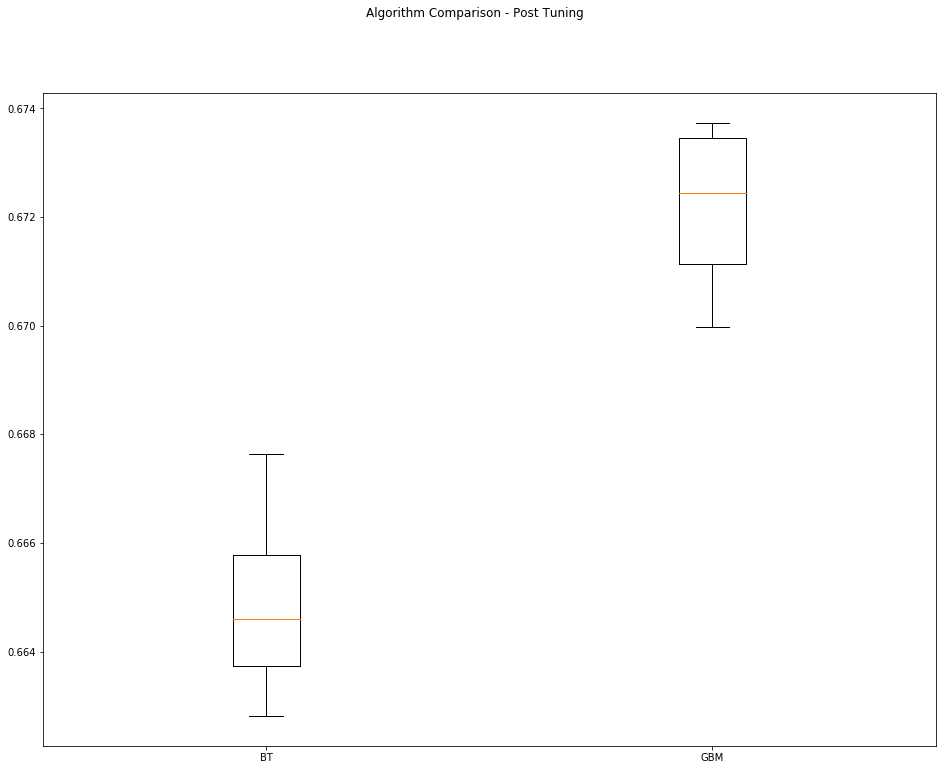

In [40]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

### 6.a) Predictions on validation dataset

In [41]:
model = GradientBoostingClassifier(n_estimators=200, random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6670590213553051
[[3397 2188]
 [1772 4537]]
             precision    recall  f1-score   support

        0.0       0.66      0.61      0.63      5585
        1.0       0.67      0.72      0.70      6309

avg / total       0.67      0.67      0.67     11894



### 6.b) Create standalone model on entire training dataset

In [42]:
startTimeModule = datetime.now()

# Combining the training and test datasets to form the original dataset that will be used for training the final model
x_train = np.vstack((x_train, x_test))
print(x_train.shape)
y_train = np.concatenate((y_train, y_test))
print(y_train.shape)

finalModel = GradientBoostingClassifier(n_estimators=200, random_state=seedNum)
finalModel.fit(x_train, y_train)
print('Model training time:',(datetime.now() - startTimeModule))

(39644, 44)
(39644,)
Model training time: 0:00:24.437013


### 6.c) Save model for later use

In [43]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:59:32.248347
